# Combined E2E analysis
This notebook relies on the condensed, pickle format of the data that has been saved out by the notebooks `iperf_data_loading` and `mcd_data_loading`

In [1]:
%matplotlib notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [354]:
from cycler import cycler
plt.style.use('seaborn-paper')
plt.rcParams['axes.prop_cycle']= cycler(color=['#e41a1c','#377eb8','#4daf4a','#984ea3'])

A helper function to render a grayscale image of a plot

In [ ]:
import matplotlib.image as mpimg
import numpy as np

def to_gscale(fig):
    fig.savefig('tmp.png', dpi=1800)
    plt.figure(figsize=(fig.get_figwidth()*2, fig.get_figheight()*2))
    img = mpimg.imread('tmp.png')
    grey = np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])
    plt.imshow(grey, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    plt.axis('off')
    plt.subplots_adjust(top=1, bottom=0, left=0, right=1)

img = to_gscale(fig)

### Data loading
Import the data from the other notebooks

In [2]:
import pickle

def load_iperf_data(dev):
    return pickle.load(open('%s_iperf.pickle' % dev, 'rb'))

def load_mcd_data(dev):
    return pickle.load(open("%s_mcd.pickle" % dev, "rb"))

def load_power_data(dev):
    return pickle.load(open("%s_powers.pickle" % dev, "rb"))

def load_rtt_data(dev):
    return pickle.load(open('%s_iperf_rtt.pickle' % dev, 'rb'))

def load_device_data(dev):
    print("Loading "+dev)
    return load_iperf_data(dev), load_mcd_data(dev), load_power_data(dev)

In [3]:
arista_throughput, (arista_latency, arista_success), arista_powers = load_device_data('arista')
fpga_throughput, (fpga_latency, fpga_success), fpga_powers = load_device_data('fpga')
tofino_throughput, (tofino_latency, tofino_success), tofino_powers = load_device_data('tofino')

Loading arista
Loading fpga
Loading tofino


In [4]:
cpu_throughput, (cpu_latency, cpu_success), cpu_powers = load_device_data('cpu')

Loading cpu


### Power analysis
These cells allow you to calculate cross-device per-experiment power utilization 

In [5]:
FPGA_DEVICES = set([
    'tofino', 'fpga12/0', 'fpga12/1', 'fpga12/2', 'fpga13/0', 'fpga13/1'
])
TOFINO_DEVICES = set([
    'tofino', 'fpga12/0', 'fpga12/1', 'fpga12/2'
])
ARISTA_DEVICES = set([
    'arista', 'fpga12/0', 'fpga12/1', 'fpga12/2', 'fpga13/0', 'fpga13/1'
])
CPU_DEVICES = set([
    'arista', 'tclust2', 'tclust4'
])
JUXTAPOSED_DEVICES = set([
    'arista', 'tofino', 'fpga13/0', 'fpga13/1', 'tclust2', 'tclust4'
])


EXPERIMENT_DEVICES = [
    set(['arista', 'tofino']),
    set(['fpga13/0', 'fpga13/1', 'tclust2', 'tclust4']),
    set([]),
    set(['fpga12/1', 'fpga12/2']),
    set(['fpga12/0']),
    set([])
]
EXPERIMENTS = [
    'baseline', 'hc', 'drop', 'fec', 'kv', 'juxtaposed'
]

def filter_experiment_devices(df, dev_list):
    all_dfs = []
    all_devs = set()
    for experiment, exp_devs in zip(EXPERIMENTS, EXPERIMENT_DEVICES):
        all_devs |= exp_devs
        all_devs &= dev_list
        all_dfs.append(df[(df.experiment == experiment) & (df.device.isin(all_devs))])
    return pd.concat(all_dfs, ignore_index=True)
        
def get_power_summary(df, dev_list):
    x = filter_experiment_devices(df, dev_list)
    x = x.assign(epoch = (x.exp_time).round(0))
    group = x.groupby(['epoch', 'device', 'experiment', 'trial'])
    means = group.mean()
    
    dfs = []
    for exp, exp_group in means.groupby('experiment', group_keys=True):
        dev_groups = exp_group.groupby(['epoch', 'trial'])
        summed = dev_groups.sum()
        counts = dev_groups.power.count()
        summed.exp_time /= counts
        summed = summed.assign(experiment = exp)
        dfs.append(summed[counts == max(counts)])

    return pd.concat(dfs, ignore_index=True)

def get_within_trial_power_summary(df, dev_list):
    x = filter_experiment_devices(df, dev_list)
    x = x.assign(epoch = (x.exp_time).round(0))
    group = x.groupby(['epoch', 'device', 'experiment', 'trial'])
    means = group.mean()
    
    dfs = []
    for (exp, trial), exp_group in means.groupby(['experiment', 'trial']):
        dev_groups = exp_group.groupby(['epoch'])
        summed = dev_groups.sum()
        counts = dev_groups.power.count()
        summed.exp_time /= counts
        summed = summed.assign(experiment = exp, trial=trial)
        dfs.append(summed[counts == max(counts)].reset_index())

    return pd.concat(dfs, ignore_index=True)

In [481]:
def juxtapose(df, exp1='baseline', exp2='hc', jux_time = 15, time_col='time'):
    """Places two experiments back-to-back on the same timeline
    Sets the experiment to be "juxtaposed"
    """
    df_before = df[(df.experiment == exp1) & (df[time_col] < jux_time)]
    df_after = df[(df.experiment == exp2) & (df[time_col] > jux_time)]
    df = pd.concat([df_before, df_after], ignore_index=True).assign(experiment = 'juxtaposed')
    return df

## E2E (boxplot) Plotting
Creating e2e boxplots with experiments in columns and measures in rows

In [347]:

BOX_WIDTH = .25
EXPERIMENTS = ['baseline', 'hc', 'drop', 'fec', 'kv']
BOXPLOT_ARGS = dict(
    showfliers=False,
    patch_artist=True,
    whis=[1, 99],
    whiskerprops=dict(linewidth=2),
    medianprops=dict(color='#555555')
)

def boxplot(df, offset=0, color=None, fmt='-', no_xtick=False,
            group_col='experiment', plot_col='value', 
            width=BOX_WIDTH, groups=EXPERIMENTS, **plot_kwargs):
    
    datas = []
    
    for group_name in groups:
        group = df[df[group_col] == group_name]
        datas.append(group[plot_col])
        
    x = np.arange(len(groups)) + offset
    medians = [np.median(d) for d in datas]
    upper_quartile = [np.percentile(d, 75) for d in datas]
    
    pl = plt.plot(x, medians, fmt, color=color, **plot_kwargs)
    bp = plt.boxplot(datas, positions=x, widths=width,
                     boxprops=dict(facecolor=color),
                     **BOXPLOT_ARGS)
    
    if not no_xtick:
        labels = [('+' if i > 0 else '')+(g.title() if len(g) > 3 else g.upper()) for i, g in enumerate(groups)]
        
        plt.gca().set_xticks(np.arange(len(labels)))
        plt.gca().set_xticklabels(labels, fontsize=10)
        for label in plt.gca().get_xticklabels():
            if label.get_text().lower() == '+drop':
                label.set_color('red')
    else:
        plt.gca().set_xticks([])
        
    med_df = pd.DataFrame([medians], columns=groups).assign(stat='median')
    low_df = pd.DataFrame([upper_quartile], columns=groups).assign(stat='75%')
        
    return pl, pd.concat([med_df, low_df], ignore_index=True)

MCD_LIMS = 7, 37        
        
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']   
    
def mcd_boxplot(mcd_data, **kwargs):
    mcd_data = mcd_data[(mcd_data.time > MCD_LIMS[0]) & (mcd_data.time < MCD_LIMS[1])]
    g, g_med = boxplot(mcd_data[mcd_data.type == 'get'], -.2, COLORS[1], linestyle='--',  **kwargs)
    s, s_med = boxplot(mcd_data[mcd_data.type == 'set'], .2, COLORS[2], linestyle=':', **kwargs)
    
    return g+s, pd.concat([g_med.assign(type='get'), s_med.assign(type='set')], ignore_index=True)


LEGEND_OPTS = {'loc': 'upper center',
               'bbox_to_anchor': (.6, 1),
               'fancybox': True,
                'ncol': 3,
               'labelspacing': 10
              }

IPERF_LIMS = 2, 32        
LINESTYLES=['--', ':', '-', 'dashdot']
SPACING = .3

def iperf_boxplot(datas, spacing=SPACING, linestyles=LINESTYLES, **kwargs):
    
    handles = []
    values = []
    for i, (d, c, l) in enumerate(zip(datas, COLORS, linestyles)):
        d = d[(d.time > IPERF_LIMS[0]) & (d.time < IPERF_LIMS[1])]
        d = d.assign(value = d.value *1e-3)
        h, v = boxplot(d, spacing * i - spacing * (len(datas)-1) / 2.0, c, linestyle=l, **kwargs )
        handles.extend(h)
        values.append(v.assign(type='iperf'))
    return handles, pd.concat(values, ignore_index=True)
    
POWER_LIMS = 10, 40    
    
def power_boxplot(pow_devs, spacing = SPACING, colors=COLORS, linestyles=LINESTYLES, **kwargs):
    print(colors)
    
    handles = []
    values = []
    for i, ((power, dev), c, l) in enumerate(zip(pow_devs, colors, linestyles)):
        
        power = power[(power.exp_time > POWER_LIMS[0]) * (power.exp_time < POWER_LIMS[1])]
        power = get_power_summary(power, dev)
        h, v = boxplot(power, spacing * i - spacing * (len(pow_devs)-1) / 2.0, c, linestyle=l, plot_col='power', **kwargs )
        handles.extend(h)
        values.append(v.assign(type='power'))
    
    return handles, pd.concat(values, ignore_index=True)


In [482]:
from matplotlib import patches

def e2e_figure(success, latency, tputs, pows):
    """The function used to create the figure shown in the paper"""
    fig, axs = plt.subplots(4, 1, figsize=(3.5, 2.86), sharex=True)

    lat_ax, succ_ax, tput_ax, power_ax = axs
    
    plt.sca(lat_ax)
    latency = latency.assign(value=latency.value * 1e6)
    handles, df1 = mcd_boxplot(latency, no_xtick=True)
    plt.yscale('log')
    plt.ylabel('Latency\n(µs)', fontsize=8)
    plt.yticks([1e1, 1e2, 1e3])
    
    plt.sca(succ_ax)
    success = success.assign(value = success.value * 100)
    handles2, df2 = mcd_boxplot(success, no_xtick=True)
    df2 = df2.assign(type=df2.type + '_success')
    plt.ylim([92, 101])
    plt.yticks([95, 100])
    plt.ylabel("Success\n(%)", fontsize=8)
    
    plt.sca(tput_ax)
    handles3, df3 = iperf_boxplot(tputs, no_xtick=True, linestyles=['dashdot'])
    plt.ylim([-1, 11])
    plt.yticks([0, 5, 10])
    plt.ylabel("Throughput\n(Gbps)", fontsize=8)
    
    plt.figlegend(handles + handles3, ['KV get', 'KV set', 'iperf'], **LEGEND_OPTS)
    
    plt.sca(power_ax)
    handles4, df4 = power_boxplot(pows, linestyles=['-'], colors=['k'])
    plt.ylabel("Power\n(W)", fontsize=8)
    plt.ylim([95, None])

    for ax in axs:
        for x in .5, 1.5, 2.5, 3.5:
            ax.axvline(x, color=[.2,.2,.2], linewidth=.5)
        ylims = ax.get_ylim()
        ax.add_patch(patches.Rectangle([1.5, ylims[0]], 1, ylims[1] - ylims[0], 
                                       fill=False, hatch='///', color='r', alpha=.2, linewidth=2))
    
    plt.subplots_adjust(top=.9, bottom=.1, left=0.18, right=.99, hspace=.05)
    plt.xlim([-.5, 4.5])
    lat_ax.xaxis.set_ticks_position('none') 
    succ_ax.xaxis.set_ticks_position('none') 
    tput_ax.xaxis.set_ticks_position('none') 
    power_ax.xaxis.set_ticks_position('none') 

    
    return fig, pd.concat([df1, df2, df3, df4], ignore_index=True)

<IPython.core.display.Javascript object>


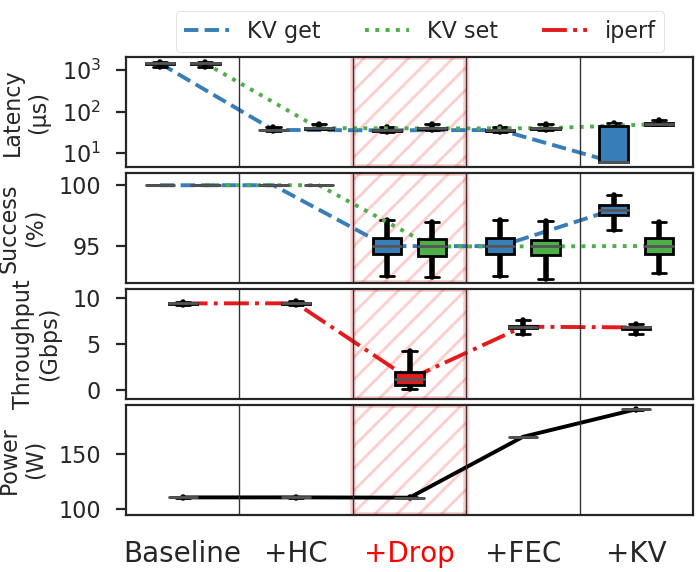

[<matplotlib.lines.Line2D object at 0x7f3215805208>, <matplotlib.lines.Line2D object at 0x7f31f6782748>] [<matplotlib.lines.Line2D object at 0x7f3213ddb240>]
['k']


/home/iped/miniconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


,baseline,hc,drop,fec,kv,stat,type
0,1432.687000,36.170000,35.446000,35.977000,6.082000,median,get
1,1487.050000,36.979000,36.209000,36.843000,45.999000,75%,get
2,1437.096000,39.943000,39.367000,39.804000,50.061000,median,set
3,1491.123000,40.851000,40.292000,40.823000,52.271000,75%,set
4,100.000000,100.000000,95.029821,95.029821,98.011928,median,get_success
5,100.000000,100.000000,95.660750,95.693008,98.418972,75%,get_success
6,100.000000,100.000000,95.004990,95.009960,95.044594,median,set_success
7,100.000000,100.000000,95.589855,95.564516,95.695218,75%,set_success
8,9.404328,9.416122,1.190604,6.866365,6.795238,median,iperf
9,9.433792,9.441256,1.939839,6.958601,6.886442,75%,iperf


In [479]:
fig, e2e_df = e2e_figure(tofino_success, tofino_latency, 
                         [tofino_throughput],
                         [(tofino_powers, TOFINO_DEVICES)])
plt.savefig('e2e_performance.pdf')
e2e_df

# Plan comparison barplots

<IPython.core.display.Javascript object>


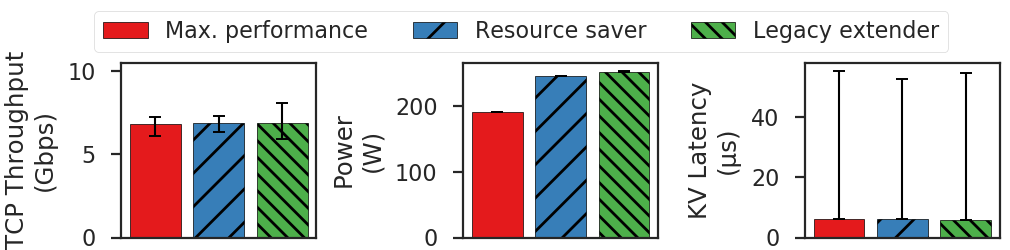

[(0.6928604928883306, 0.409697389311674)]
[(0.5107010607550775, 0.4274123333170401)]
[(0.9701259173206758, 1.2126212734700923)]
[(0.3329999999999984, 0.24100000000001387)]
[(0.47399999999998954, 0.25745000000000573)]
[(1.096274999999963, 1.1985500000000684)]
[(0.09600000083764826, 49.386969997442726)]
[(0.09499999009676685, 46.75200001003077)]
[(0.025000005621222954, 49.09799999097686)]


In [480]:
import seaborn as sns
sns.set_style('ticks')
HATCHES = [None, '//', r'\\\\', 'xx']

def target_barplot(dfs, experiment, labels, value_col = 'value'):
    width = .8
    handles = []
    
    for i, (hatch, df) in enumerate(zip(HATCHES, dfs)):
        vals = []
        errs = []
        df = df[df.experiment == experiment]
        if len(df) == 0:
            vals.append(0)
            errs.append((0, 0))
            continue
        med = df[value_col].median()
        vals.append(med)
        low = np.percentile(df[value_col], 1)
        high = np.percentile(df[value_col], 99)
        errs.append((med - low, high - med))
        print(errs)    
            
        handles.append(plt.bar([i], vals, edgecolor='k', linewidth=.25, width=width, yerr=list(zip(*errs)), hatch=hatch, error_kw={'capsize': 2, 'color': 'k', 'linewidth': .75, 'markeredgewidth': .7}))
        
    plt.xticks([])
        
def iperf_grouped_barplot(dfs, labels, **kwargs):
    dfs = [df.assign(value = df.value * 1e-3) for df in dfs]
    target_barplot(dfs, 'kv', labels, **kwargs)
    
def power_grouped_barplot(dfdevs, labels, **kwargs):
    newdfs = []
    for df, dev in dfdevs:
        newdf = get_within_trial_power_summary(df, dev)
        newdf = newdf[(newdf.exp_time > POWER_LIMS[0]) & (newdf.exp_time < POWER_LIMS[1])]
        newdfs.append(newdf)
    target_barplot(newdfs, 'kv', labels, 'power', **kwargs)

def latency_grouped_barplot(dfs, labels, **kwargs):
    dfs = [df.assign(value = df.value * 1e6) for df in dfs]
#     dfs = [df[df.type == 'get'] for df in dfs]
    target_barplot(dfs, 'kv', labels, **kwargs)
    
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(5.05, 1.25))
plt.sca(ax1)

h = iperf_grouped_barplot([tofino_throughput,fpga_throughput, arista_throughput],
                          ['P.ASIC', 'P.ASIC+FPGA', 'ASIC+FPGA'])

ax1.set_ylim([0, 10.5])
ax1.set_ylabel("TCP Throughput\n(Gbps)")
plt.sca(ax2)
h = power_grouped_barplot([(tofino_powers, TOFINO_DEVICES),
                           (fpga_powers, FPGA_DEVICES),
                         (arista_powers, ARISTA_DEVICES)],
                         ['P.ASIC', 'P.ASIC+FPGA', 'ASIC+FPGA'])

ax2.set_ylabel("Power\n(W)")

plt.sca(ax3)
h = latency_grouped_barplot([tofino_latency,fpga_latency, arista_latency],
                            ['P.ASIC', 'P.ASIC+FPGA', 'ASIC+FPGA'])

ax3.set_ylabel("KV Latency\n(µs)")

plt.figlegend(handles = h, labels=['Max. performance', 'Resource saver', 'Legacy extender'], loc='upper right', ncol=4, bbox_to_anchor=(.95, 1))    
plt.tight_layout()
plt.subplots_adjust(top=.75, right=.99, left=.12, bottom=.05, wspace=.75)
plt.savefig("cross_platform_barplot_with_latency.pdf")

## Alternate e2e plots
(These functions didn't wind up being used in the final paper)

In [992]:

def e2e_figure_2x2(success, latency, tputs, pows):
    fig, axs = plt.subplots(2,2, figsize=(6, 2.5), sharex=True)

    ( power_ax, lat_ax), (tput_ax,  succ_ax) = axs
    plt.sca(lat_ax)
    latency = latency.assign(value=latency.value * 1e6)
    handles = mcd_boxplot(latency, no_xtick=True)
    plt.yscale('log')
    plt.ylabel('Latency\n(µs)')
    plt.yticks([1e1, 1e2, 1e3])
    lat_ax.yaxis.tick_right()
    lat_ax.yaxis.set_label_position("right")
    lat_ax.legend(handles, ['Get', 'Set'], **LEGEND_OPTS)
    
    plt.sca(succ_ax)
    success = success.assign(value = success.value * 100)
    handles = mcd_boxplot(success, no_xtick=True)
    plt.ylim([92, 101])
    plt.yticks([95, 100])
    plt.ylabel("Success\n(%)")
    succ_ax.yaxis.tick_right()
    succ_ax.yaxis.set_label_position("right")
    
    plt.sca(tput_ax)
    handles = iperf_boxplot(tputs, no_xtick=True)
    plt.ylim([0, 11])
    plt.yticks([5, 10])
    plt.ylabel("Throughput\n(Gbps)")

    plt.sca(power_ax)
    handles = power_boxplot(pows)
    plt.ylabel("Power\n(W)")
    plt.ylim([99, None])
    
    for ax1 in axs:
        for ax in ax1:
            for x in .5, 1.5, 2.5, 3.5:
                ax.axvline(x, color=[.2,.2,.2], linewidth=.5)
            ylims = ax.get_ylim()
            ax.add_patch(patches.Rectangle([1.5, ylims[0]], 1, ylims[1] - ylims[0], 
                                           fill=False, hatch='///', color='r', alpha=.2, linewidth=2))
    
    plt.subplots_adjust(top=.85, bottom=.1, left=0.13, right=.85, hspace=.1, wspace=.1)    
    
    plt.xlim([-.5, 4.5])
    return fig

<IPython.core.display.Javascript object>


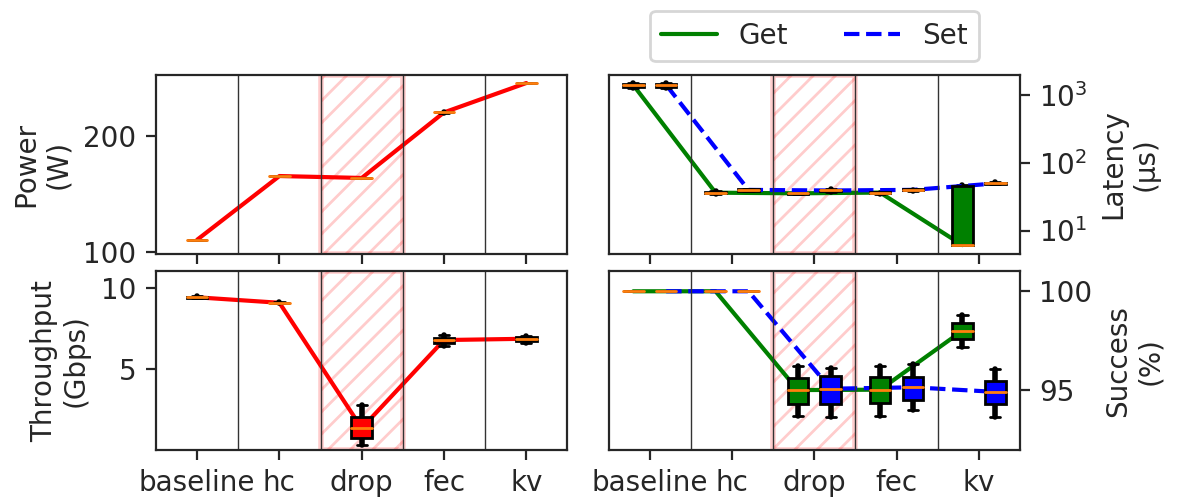

/home/iped/miniconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


In [993]:
fig = e2e_figure_2x2(fpga_success, fpga_latency, 
                 [fpga_throughput],
                 [(fpga_powers, FPGA_DEVICES)])

<IPython.core.display.Javascript object>


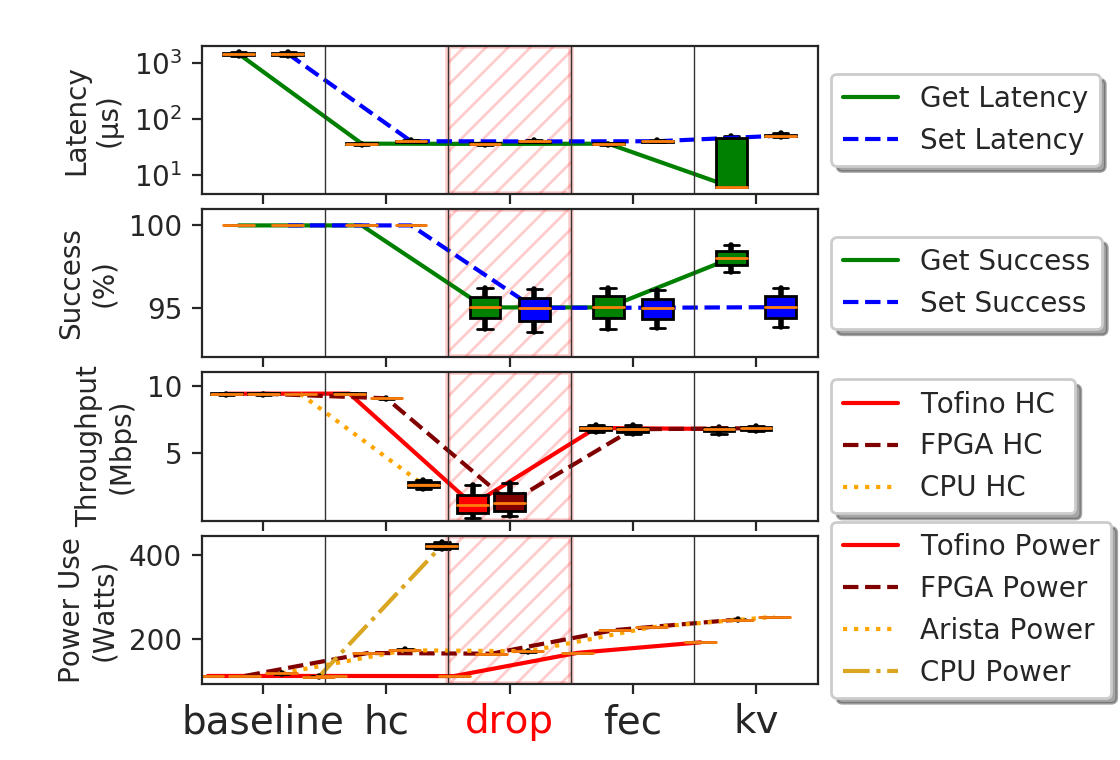

/home/iped/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/iped/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/iped/miniconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/home/iped/miniconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/home/iped/miniconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space becaus

In [477]:
### Show all functions on one plot
fig = e2e_figure(tofino_success, tofino_latency, 
                 [tofino_throughput, fpga_throughput, cpu_throughput],
                 [(tofino_powers, TOFINO_DEVICES),
                  (fpga_powers, FPGA_DEVICES),
                  (arista_powers, ARISTA_DEVICES),
                  (cpu_powers, CPU_DEVICES)])


In [49]:
def plot_timeseries(df, experiment, time_column='time', value_column='value', *args, **kwargs):
    print(experiment)
    if experiment is None:
        df = juxtapose(df, time_col=time_column)
    else:
        df = df[df.experiment == experiment]

    counts = df.groupby(time_column).count().reset_index()[value_column]
    max_df = df.groupby(time_column).agg(lambda x: np.percentile(x, 99)).reset_index()[counts > 1]
    min_df = df.groupby(time_column).agg(lambda x: np.percentile(x, 1)).reset_index()[counts > 1]
    median_df = df.groupby(time_column).median().reset_index()[counts > 1]
    
    plt.fill_between(max_df[time_column], min_df[value_column], max_df[value_column], ls='-', edgecolor='face', alpha=.2)
    return plt.plot(median_df[time_column], median_df[value_column], *args, linewidth=1, **kwargs)
    
def plot_throughput_timeseries(df, experiment, loss_instead = False, *args, **kwargs):
    df = df.assign(value=df.value * 1e-3)
    if loss_instead:
        df = df.assign(value = 10 - df.value)
    return plot_timeseries(df, experiment, 'time', 'value', *args, **kwargs)
    
def plot_power_timeseries(df, experiment, devices, subtract_min=False, *args, **kwargs):
    df = df[df.trial <= 5]
    df.exp_time -= 5
    df = df[(df.exp_time > -10) & (df.exp_time < 50)]
    if experiment is None:
        devices = devices & JUXTAPOSED_DEVICES
        df = get_within_trial_power_summary(df, devices)
        df = juxtapose(df, time_col = 'exp_time')
    if subtract_min:
        df.power -= df.power.min()
    return plot_timeseries(df, 'juxtaposed', 'epoch', 'power', *args, **kwargs)

def plot_latency_timeseries(df, experiment, *args, **kwargs):
    df = df.copy()
    df.time -= 5
    df = df[df.exp_label <= 5]
    df = df.assign(epoch = (df.time).round(0))
    df.value *= 1e6
    return plot_timeseries(df, experiment, 'epoch', 'value', *args, **kwargs)

def plot_rtt_timeseries(df, experiment, *args, **kwargs):
    df = df[df.trial <= 5]
    df = df.assign(epoch = (df.time).round(0))
    df.value *= 1e3
    return plot_timeseries(df, experiment, 'epoch', 'value', *args, **kwargs)

### Timeseries plotting
Power and throughput plot that wound up being replaced by a table in the paper

<IPython.core.display.Javascript object>


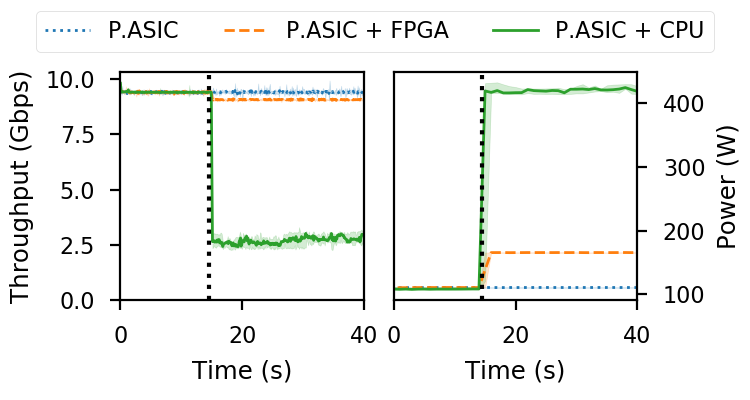

None
None
None
juxtaposed
juxtaposed


/home/iped/miniconda3/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


juxtaposed


In [324]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(3.75, 2))
plt.sca(ax1)
exp = None

plot_throughput_timeseries(tofino_throughput, exp, False, ':')
plot_throughput_timeseries(fpga_throughput, exp, False, '--')
plot_throughput_timeseries(cpu_throughput, exp)
ax1.set_ylabel("Throughput (Gbps)")
ax1.set_xlabel("Time (s)")
ax1.set_ylim([0, None])

plt.xlim([0, 40])
ax1.set_xticks([0, 20, 40])
ax1.axvline(14.5, color='k', linestyle=':', linewidth=1.5)

plt.sca(ax2)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')

t = plot_power_timeseries(tofino_powers, exp, TOFINO_DEVICES, False, ':')
f = plot_power_timeseries(fpga_powers, exp, FPGA_DEVICES, False,  '--')
c = plot_power_timeseries(cpu_powers, exp, CPU_DEVICES, False)
ax2.set_ylabel("Power (W)")
ax2.set_xlabel("Time (s)")
plt.xlim([0, 40])
ax2.set_xticks([0, 20, 40])
ax2.axvline(14.5, color='k', linestyle=':', linewidth=1.5)

plt.sca(ax1)

plt.figlegend(t+f+c, ['P.ASIC', 'P.ASIC + FPGA', 'P.ASIC + CPU'],
           loc='upper center', fancybox=True , ncol=3, shadow=False)
plt.tight_layout()

plt.subplots_adjust(top=.82, wspace=.12, bottom=.25, right=.85)


plt.savefig('use_case_characteristics.pdf')

In [23]:
tofino_rtt = load_rtt_data('tofino')
fpga_rtt = load_rtt_data('fpga')
cpu_rtt = load_rtt_data('cpu')


<IPython.core.display.Javascript object>


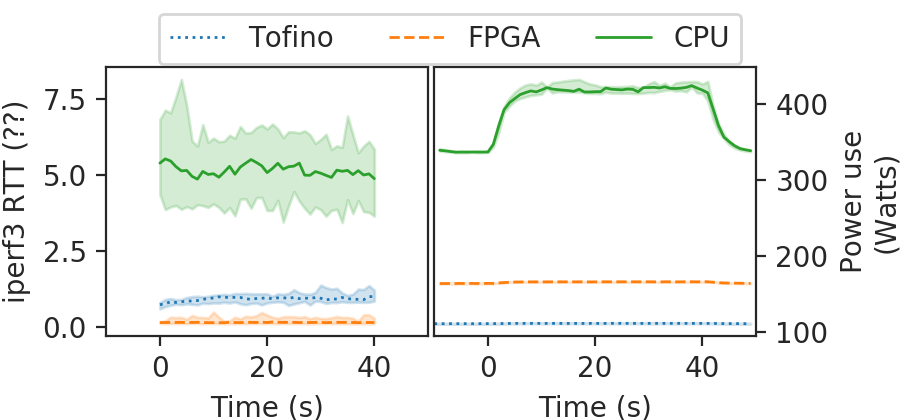

In [493]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4.5, 2.1))
plt.sca(ax1)
plot_rtt_timeseries(tofino_rtt, 'hc', ':')
plot_rtt_timeseries(fpga_rtt, 'hc', '--')
plot_rtt_timeseries(cpu_rtt, 'hc')
ax1.set_ylabel("iperf3 RTT (??)")
ax1.set_xlabel("Time (s)")

plt.xlim([-10, 50])
ax1.set_xticks([0, 20, 40])


plt.sca(ax2)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')

t = plot_power_timeseries(tofino_powers, 'hc', TOFINO_DEVICES, ':')
f = plot_power_timeseries(fpga_powers, 'hc', FPGA_DEVICES, '--')
c = plot_power_timeseries(cpu_powers, 'hc', CPU_DEVICES)
ax2.set_ylabel("Power use\n(Watts)")
ax2.set_xlabel("Time (s)")
plt.xlim([-10, 50])
ax2.set_xticks([0, 20, 40])
plt.sca(ax1)
plt.tight_layout()

plt.figlegend(t+f+c, ['Tofino', 'FPGA', 'CPU'],
           loc='upper center', fancybox=True , ncol=3, shadow=False)
plt.subplots_adjust(top=.84, wspace=.02, right=.84, bottom=.2)



# Barplots
Barplot used in paper to show comparison of different devices, 

<IPython.core.display.Javascript object>


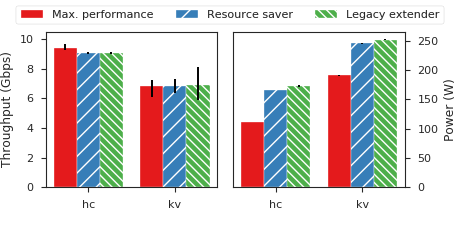

/home/iped/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


In [379]:
import seaborn as sns
sns.set_style('ticks')
HATCHES = [None, '//', r'\\\\', 'xx']
BARPLOT_EXPS = ['hc', 'kv']

def grouped_barplot(dfs, experiments, value_col = 'value'):
    width = .8 / len(dfs)
#     base_x = np.arange(len(experiments))
    
    handles = []
    
    for i, (hatch, df) in enumerate(zip(HATCHES, dfs)):
        vals = []
        errs = []
        for exp in experiments:
            if not (df.experiment == exp).any():
#                 vals.append(0)
#                 errs.append((0, 0))
                continue
            med = df[df.experiment == exp][value_col].median()
            vals.append(med)
            low = np.percentile(df[df.experiment == exp][value_col], 1)
            high = np.percentile(df[df.experiment == exp][value_col], 99)
            errs.append((med - low, high - med))
            
        base_x = np.arange(len(errs))
#         print(vals)
        handles.append(plt.bar(base_x + i * width, vals, width=width, yerr=list(zip(*errs)), capsize=2, hatch=hatch))
        
    plt.xticks(np.arange(len(experiments)) + width * (len(dfs) - 1)/2)
    plt.gca().set_xticklabels(experiments)
        
def iperf_grouped_barplot(dfs, **kwargs):
    dfs = [df.assign(value = df.value * 1e-3) for df in dfs]
    grouped_barplot(dfs, BARPLOT_EXPS, **kwargs)
    
def power_grouped_barplot(dfdevs, **kwargs):
    newdfs = []
    for df, dev in dfdevs:
        newdf = get_within_trial_power_summary(df, dev)
        newdf = newdf[(newdf.exp_time > POWER_LIMS[0]) & (newdf.exp_time < POWER_LIMS[1])]
        newdfs.append(newdf)
#     return newdfs
    grouped_barplot(newdfs, BARPLOT_EXPS, 'power', **kwargs)
    
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(4.6, 2.25))
plt.sca(ax1)

h = iperf_grouped_barplot([tofino_throughput,fpga_throughput, arista_throughput])

ax1.set_ylim([0, 10.5])
ax1.set_ylabel("Throughput (Gbps)")
plt.sca(ax2)
h = power_grouped_barplot([(tofino_powers, TOFINO_DEVICES),
                           (fpga_powers, FPGA_DEVICES),
                         (arista_powers, ARISTA_DEVICES),
                          ])

ax2.yaxis.tick_right()
ax2.set_ylabel("Power (W)")
ax2.yaxis.set_label_position('right')

plt.figlegend(h, labels=['Max. performance', 'Resource saver', 'Legacy extender'], loc='upper center', ncol=3)    
plt.tight_layout()
plt.subplots_adjust(top=.86, right=.88, left=.1)
plt.savefig("cross_platform_barplot.pdf")

In [305]:
plt.subplots_adjust(top=.86, right=.88, left=.1)


<IPython.core.display.Javascript object>


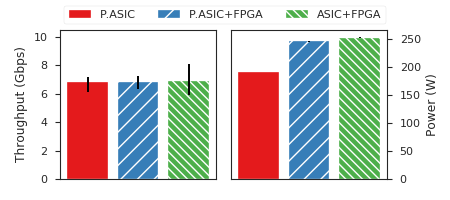

[6.8019236257826154]
[6.8451429496966005]
[6.88407962170785]
[190.87]
[245.185]
[251.73499999999996]


/home/iped/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


In [378]:
import seaborn as sns
sns.set_style('ticks')
HATCHES = [None, '//', r'\\\\', 'xx']

def target_barplot(dfs, experiment, labels, value_col = 'value'):
    width = .8
    handles = []
    
    for i, (hatch, df) in enumerate(zip(HATCHES, dfs)):
        vals = []
        errs = []
        df = df[df.experiment == experiment]
        if len(df) == 0:
            vals.append(0)
            errs.append((0, 0))
            continue
        med = df[value_col].median()
        vals.append(med)
        print(vals)
        low = np.percentile(df[value_col], 1)
        high = np.percentile(df[value_col], 99)
        errs.append((med - low, high - med))
            
        handles.append(plt.bar([i], vals, width=width, yerr=list(zip(*errs)), capsize=2, hatch=hatch))
        
    plt.xticks([])
        
def iperf_grouped_barplot(dfs, labels, **kwargs):
    dfs = [df.assign(value = df.value * 1e-3) for df in dfs]
    target_barplot(dfs, 'kv', labels, **kwargs)
    
def power_grouped_barplot(dfdevs, labels, **kwargs):
    newdfs = []
    for df, dev in dfdevs:
        newdf = get_within_trial_power_summary(df, dev)
        newdf = newdf[(newdf.exp_time > POWER_LIMS[0]) & (newdf.exp_time < POWER_LIMS[1])]
        newdfs.append(newdf)
    target_barplot(newdfs, 'kv', labels, 'power', **kwargs)

def latency_grouped_barplot(dfs, labels, **kwargs):
    dfs = [df.assign(value = df.value * 1e6) for df in dfs]
    target_barplot(dfs, 'kv', labels, **kwargs)
    
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(4.5, 2))
plt.sca(ax1)

h = iperf_grouped_barplot([tofino_throughput,fpga_throughput, arista_throughput,  cpu_throughput],
                          ['P.ASIC', 'P.ASIC+FPGA', 'ASIC+FPGA', 'P.ASIC+CPU'])

ax1.set_ylim([0, 10.5])
ax1.set_ylabel("Throughput (Gbps)")
plt.sca(ax2)
h = power_grouped_barplot([(tofino_powers, TOFINO_DEVICES),
                           (fpga_powers, FPGA_DEVICES),
                         (arista_powers, ARISTA_DEVICES),
                          (cpu_powers, CPU_DEVICES),],
                         ['P.ASIC', 'P.ASIC+FPGA', 'ASIC+FPGA', 'P.ASIC+CPU'])

ax2.yaxis.tick_right()
ax2.set_ylabel("Power (W)")
ax2.yaxis.set_label_position('right')

plt.figlegend(h, labels=['P.ASIC', 'P.ASIC+FPGA', 'ASIC+FPGA'], loc='upper center', ncol=4)    
plt.tight_layout()
plt.subplots_adjust(top=.85, right=.86)
plt.savefig("cross_platform_barplot_kv_only.pdf")